In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np

from regraph.neo4j.graphs import Neo4jGraph
import regraph.neo4j.cypher_utils as cyq
import regraph.neo4j.result_utils as rsu

import benchmark as bc

In [2]:
# initialize the neo4j driver, wrappped into Neo4jGraph object
g = Neo4jGraph(uri="bolt://localhost:7687", user="neo4j", password="admin")

In [3]:
res = g.clear()
nodes = [
    ("a", {"name": "EGFR", "state": "p"}),
    ("b", {"name": "BND"}),
    ("c", {"name": "Grb2", "aa": "S", "loc": 90}),
    ("d", {"name": "SH2"}),
    ("e", {"name": "EGFR"}),
    ("f", {"name": "BND"}),
    ("g", {"name": "Grb2"}),
    ("h", {"name": "WAF1"}),
    ("i", {"name": "BND"}),
    ("j", {"name": "G1-S/CDK", "state": "p"}),
    "k", "l", "m"
    ]
edges = [
    ("a", "b", {"s": "p"}),
    ("d", "b", {"s": "u"}),
    ("d", "c"),
    ("e", "f", {"s": "p"}),
    ("g", "f", {"s": "u"}),
    ("h", "i"),
    ("i", "h"),
    ("j", "h", {"act": {1}}),
    ("j", "i", {"act": {2}}),
    ("k", "l"),
    ("l", "k"),
    ("l", "m"),
    ("m", "l"),
    ("k", "m"),
    ("m", "k"),
    ("e", "b", {"s": "u"})
    ]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

## Profiling a query

In [4]:
res = g.clone_node("e", profiling=True)

In [30]:
res.summary().profile._fields

('operator_type', 'identifiers', 'arguments', 'children', 'db_hits', 'rows')

## Benchmark of update queries 

In [6]:
with open('stats_middle.pickle', 'rb') as f:
    stats = pickle.load(f)

In [7]:
stats.keys()

dict_keys(['warming_w_constr', 'warmed_apoc_w_constr', 'warmed_w_constr', 'constraint'])

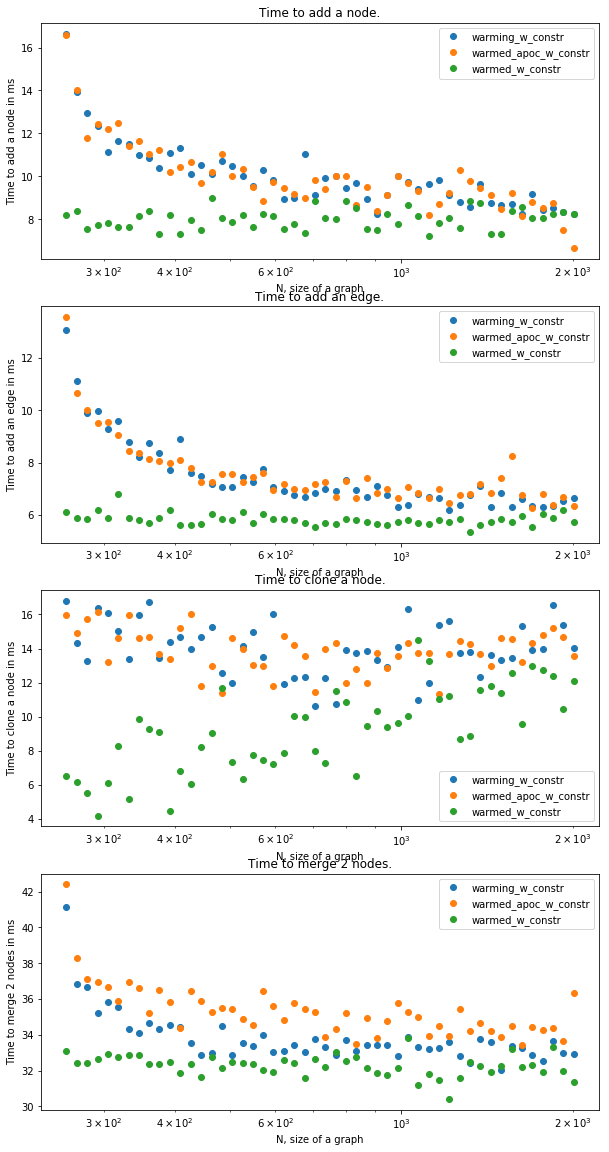

In [8]:
bc.plot_stats(stats, ['warming_w_constr', 'warmed_apoc_w_constr', 'warmed_w_constr'])

#### Time to set a constraint

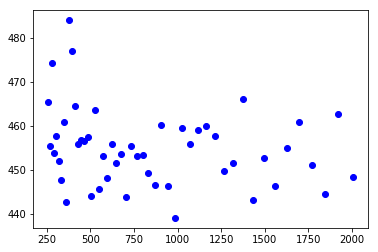

In [13]:
x = stats['constraint']['size']
y = [v[0] for v in stats['constraint']['time']]
plt.plot(x, y, 'bo')
plt.show()

## Time to clone and number of edges

In [10]:
with open("logspaced_scale_free1.pickle", 'rb') as f:
    graphs = pickle.load(f)
g = graphs[49]
stats = dict()
bc.clone_node_benchmark1(stats, g)


Graph of size 248...


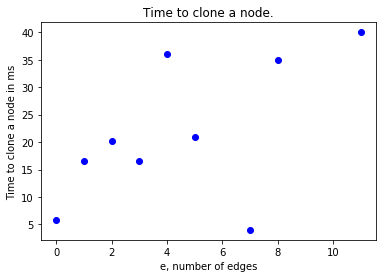

In [18]:
d = stats[248]["time"]
fig = plt.figure()
ax = fig.add_subplot(111)
for k in d.keys():
    ax.plot(k, np.mean(d[k]), 'bo')
ax.set_title('Time to clone a node.')
ax.set_xlabel('e, number of edges')
ax.set_ylabel('Time to clone a node in ms')
plt.show()

The problem is that there is a lot of data for 0 and 1 edge and not much for more than 5 edges (because it's a scale free graph). 

### Db hits and other parameters

In [33]:
cond = 'warmed_w_constr'
met = 'add_node'

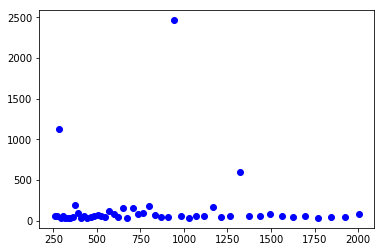

In [35]:
x = stats[cond][met]['size']
y = [v[0] for v in stats[cond][met]['db_hits']]
plt.plot(x, y, 'bo')
plt.show()